<a href="https://colab.research.google.com/github/Mena-E/DS-Unit-2-Linear-Models/blob/master/LS_DS_211_assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science

*Unit 2, Sprint 1, Module 1*

---

# Regression 1

## Assignment

You'll use another **New York City** real estate dataset. 

But now you'll **predict how much it costs to rent an apartment**, instead of how much it costs to buy a condo.

The data comes from renthop.com, an apartment listing website.

- [ ] Look at the data. Choose a feature, and plot its relationship with the target.
- [ ] Use scikit-learn for linear regression with one feature. You can follow the [5-step process from Jake VanderPlas](https://jakevdp.github.io/PythonDataScienceHandbook/05.02-introducing-scikit-learn.html#Basics-of-the-API).
- [ ] Define a function to make new predictions and explain the model coefficient.
- [ ] Organize and comment your code.

> [Do Not Copy-Paste.](https://docs.google.com/document/d/1ubOw9B3Hfip27hF2ZFnW3a3z9xAgrUDRReOEo-FHCVs/edit) You must type each of these exercises in, manually. If you copy and paste, you might as well not even do them. The point of these exercises is to train your hands, your brain, and your mind in how to read, write, and see code. If you copy-paste, you are cheating yourself out of the effectiveness of the lessons.

If your **Plotly** visualizations aren't working:
- You must have JavaScript enabled in your browser
- You probably want to use Chrome or Firefox
- You may need to turn off ad blockers
- [If you're using Jupyter Lab locally, you need to install some "extensions"](https://plot.ly/python/getting-started/#jupyterlab-support-python-35)

## Stretch Goals
- [ ] Do linear regression with two or more features.
- [ ] Read [The Discovery of Statistical Regression](https://priceonomics.com/the-discovery-of-statistical-regression/)
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapter 2.1: What Is Statistical Learning?

In [ ]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Applied-Modeling/master/data/'

# If you're working locally:
else:
    DATA_PATH = '../data/'
    
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [ ]:
# Read New York City apartment rental listing data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(DATA_PATH+'apartments/renthop-nyc.csv')
assert df.shape == (49352, 34)

In [ ]:
# Remove outliers: 
# the most extreme 1% prices,
# the most extreme .1% latitudes, &
# the most extreme .1% longitudes
df = df[(df['price'] >= 1375) & (df['price'] <= 15500) & 
        (df['latitude'] >=40.57) & (df['latitude'] < 40.99) &
        (df['longitude'] >= -74.1) & (df['longitude'] <= -73.38)]

#I. Data Wrangling

In [ ]:
df.head(2) # First two rows

bathrooms  bedrooms  ... wheelchair_access common_outdoor_space
0        1.5         3  ...                 0                    0
1        1.0         2  ...                 0                    0

[2 rows x 34 columns]

In [ ]:
df.describe(exclude='number') # Checking categorical variables

created description  ... street_address interest_level
count                 48818       47393  ...          48808          48818
unique                48149       37854  ...          15136              3
top     2016-06-12 13:20:45              ...  3333 Broadway            low
freq                      3        1627  ...            174          33947

[4 rows x 5 columns]

In [ ]:
# Drop columns with high cardinality from dataframe
df.drop(columns=['created',	'description', 'display_address',	'street_address'], inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 48818 entries, 0 to 49351
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   bathrooms             48818 non-null  float64
 1   bedrooms              48818 non-null  int64  
 2   latitude              48818 non-null  float64
 3   longitude             48818 non-null  float64
 4   price                 48818 non-null  int64  
 5   interest_level        48818 non-null  object 
 6   elevator              48818 non-null  int64  
 7   cats_allowed          48818 non-null  int64  
 8   hardwood_floors       48818 non-null  int64  
 9   dogs_allowed          48818 non-null  int64  
 10  doorman               48818 non-null  int64  
 11  dishwasher            48818 non-null  int64  
 12  no_fee                48818 non-null  int64  
 13  laundry_in_building   48818 non-null  int64  
 14  fitness_center        48818 non-null  int64  
 15  pre-war            

In [ ]:
# Function to help convert interest_level column to numericals
def make_nums(col):
  """
  function takes a column string and converts its category
  to numbers 1, 2, or 3 for 'low', 'medium' and 'high'
  respectively.
  """
  if col == 'low':
    return 1
  elif col == 'medium':
    return 2
  else:
    return 3

In [ ]:
# Create a new feature called 'new_interest_level 
df['new_interest_level'] = df['interest_level'].apply(make_nums)
df['new_interest_level'].unique()

array([2, 1, 3])

In [ ]:
# Create a new feature called 'pets_allowed' from dogs_allowed and cats_allowed columns
df['pets_allowed'] = np.where((df['dogs_allowed']==1) | (df['cats_allowed']==1), 1, 0)
df['pets_allowed'].unique()

array([0, 1])

In [ ]:
# Create new column 'total_rooms' combining the bathrooms and bedrooms columns
df['total_rooms'] = df['bathrooms'] + df['bedrooms']
df['total_rooms'].unique()

array([ 4.5,  3. ,  2. ,  5. ,  6. ,  1. ,  4. ,  7.5,  7. ,  3.5,  5.5,
        2.5,  0. ,  8. ,  9. ,  6.5, 10. , 12. ,  1.5,  8.5, 11. ])

In [ ]:
# Create a new column 'laundry' from laundry_in_building and 'laundry_in_unit
df['laundry'] = np.where((df['laundry_in_building']==1) | (df['laundry_in_unit']==1), 1, 0)
df['laundry'].unique()

array([0, 1])

In [ ]:
df.head() # display new dataframe with new features

bathrooms  bedrooms  latitude  ...  pets_allowed  total_rooms laundry
0        1.5         3   40.7145  ...             0          4.5       0
1        1.0         2   40.7947  ...             1          3.0       0
2        1.0         1   40.7388  ...             0          2.0       1
3        1.0         1   40.7539  ...             0          2.0       0
4        1.0         4   40.8241  ...             0          5.0       0

[5 rows x 34 columns]

In [ ]:
# Select columns desired for regression analysis
df = df[['bathrooms','bedrooms','total_rooms','latitude',
         'longitude','price','pets_allowed','new_interest_level',
         'laundry_in_building','laundry_in_unit','laundry']]
df.head()

bathrooms  bedrooms  ...  laundry_in_unit  laundry
0        1.5         3  ...                0        0
1        1.0         2  ...                0        0
2        1.0         1  ...                0        1
3        1.0         1  ...                0        0
4        1.0         4  ...                0        0

[5 rows x 11 columns]

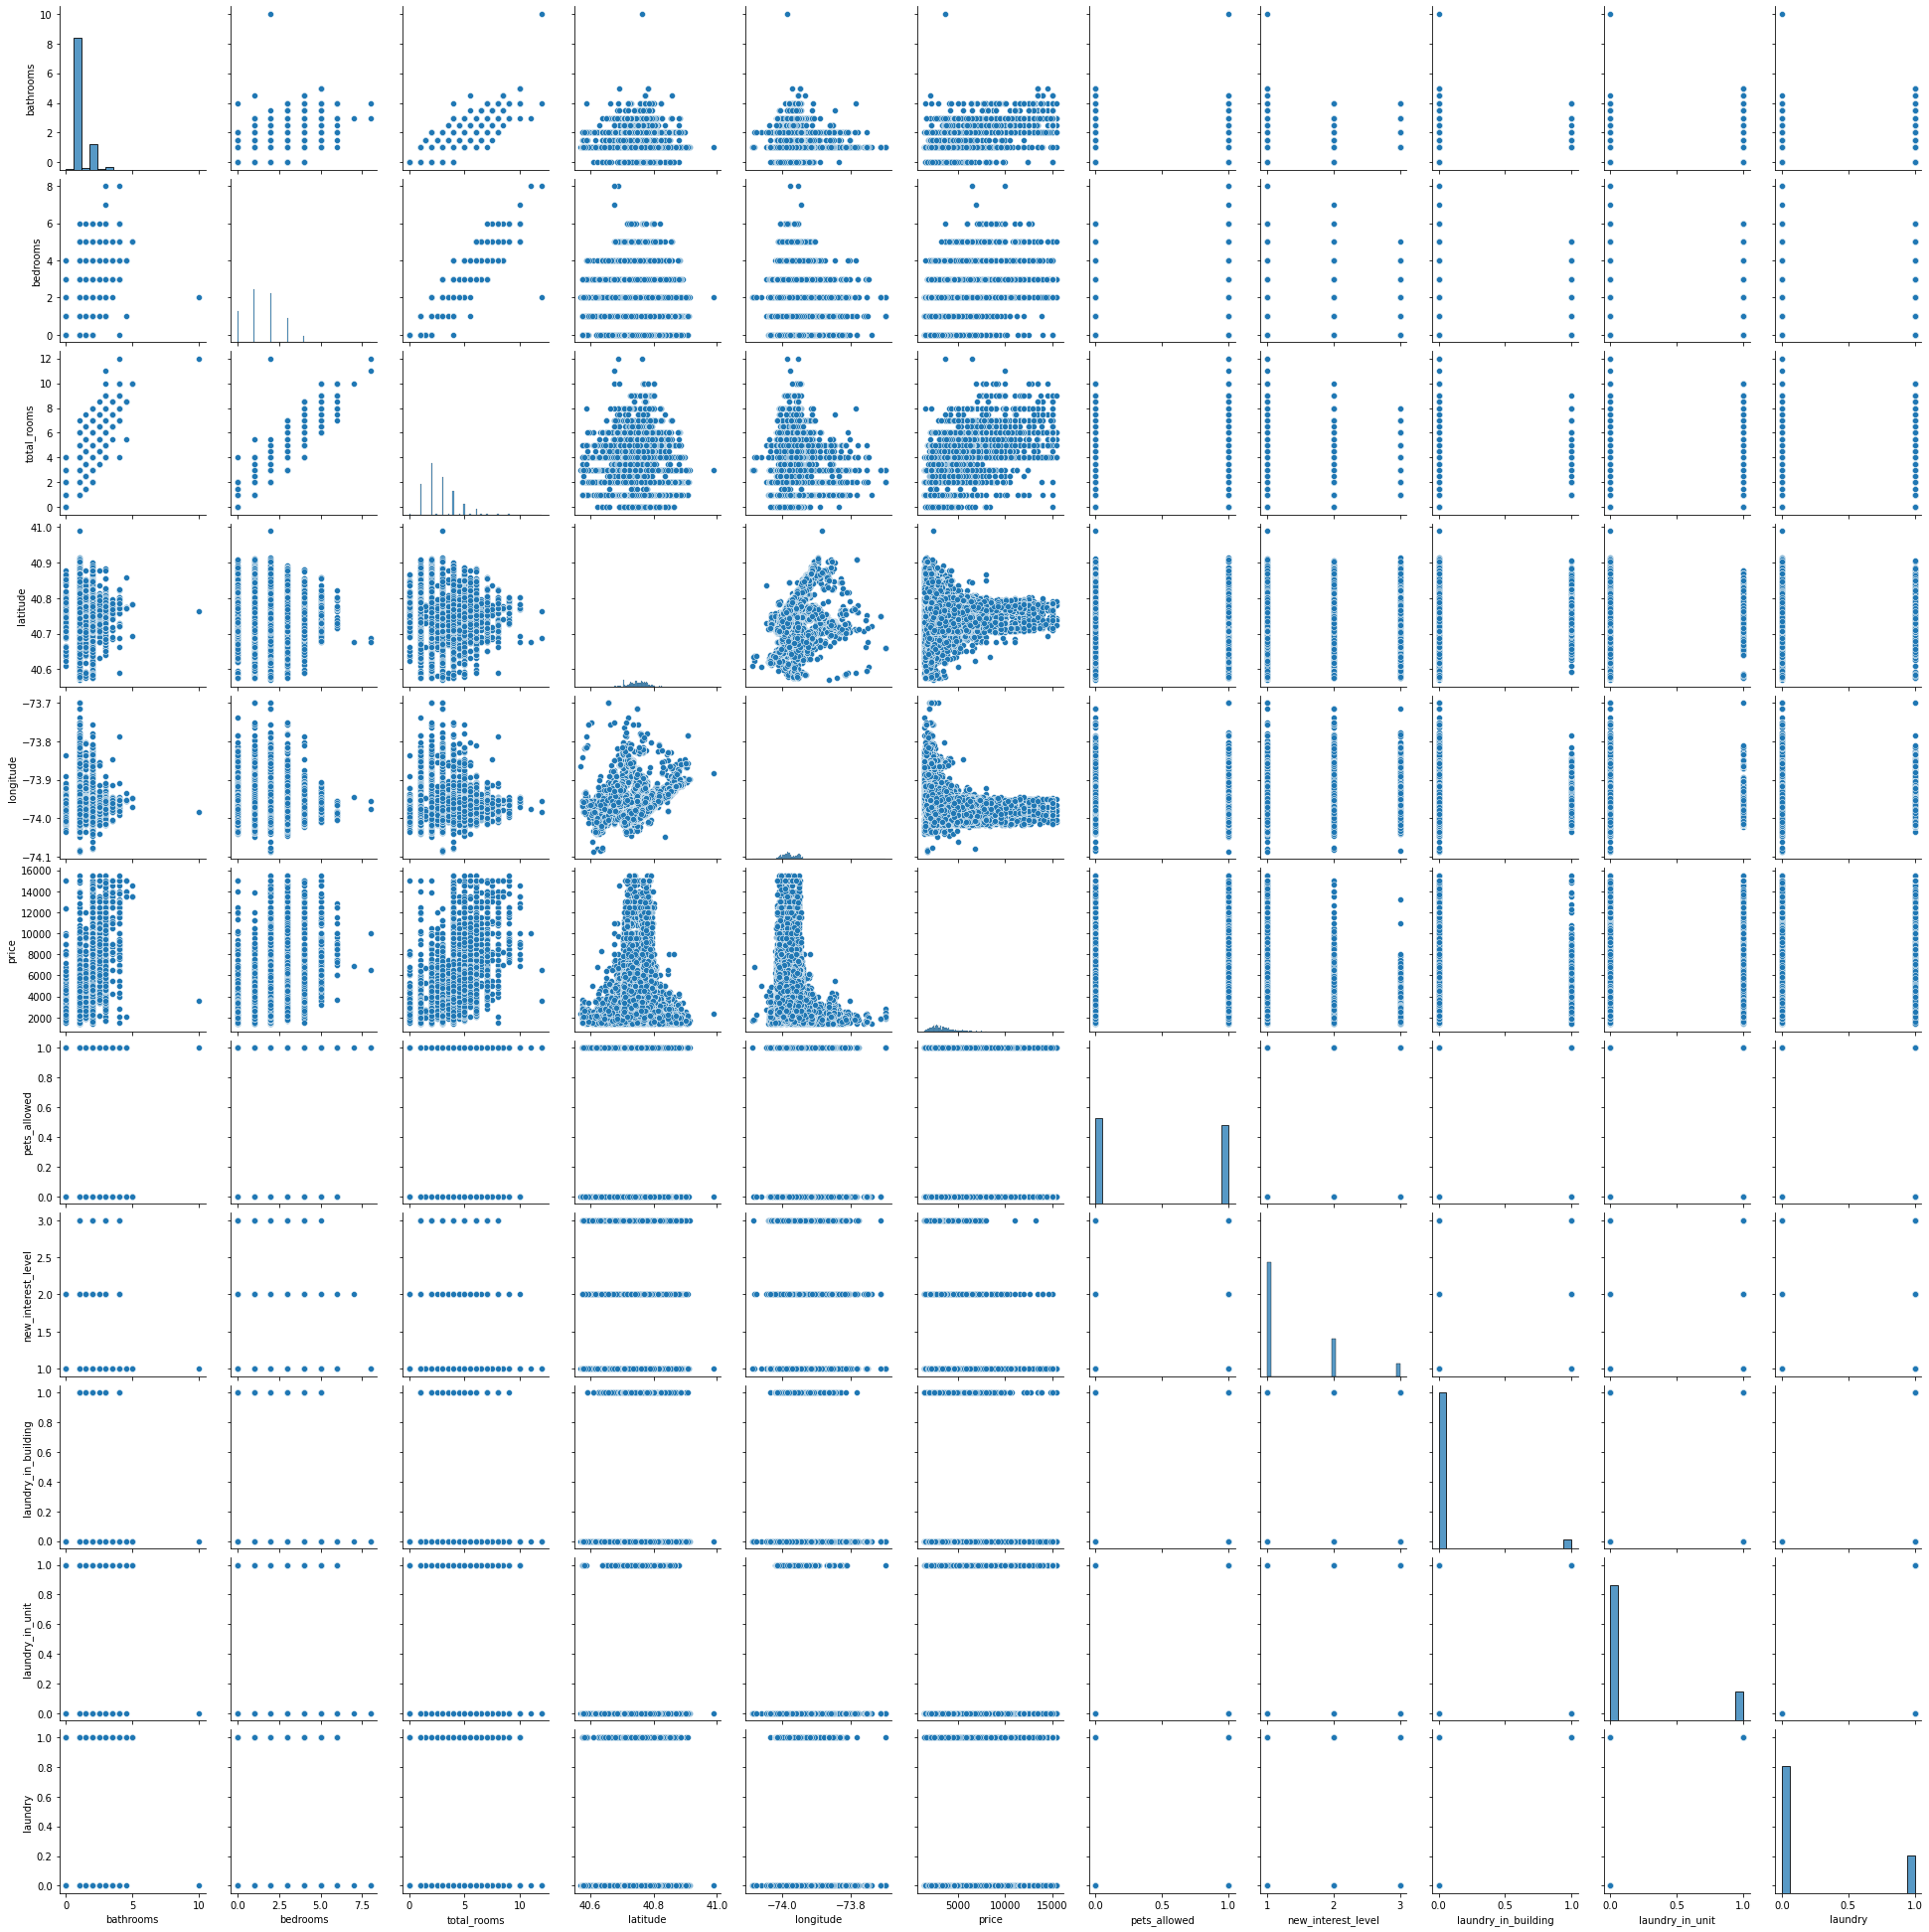

In [ ]:
sns.pairplot(df); # This is to have a quick view of any linear relationships between features and price

In [ ]:
# Check trendlines on price v number of bathrooms based on interest level
import plotly.express as px
px.scatter(df, x='bathrooms', y='price',facet_col='new_interest_level', trendline ='ols')

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
# Check trendlines on price v number of bedrooms based on interest level
import plotly.express as px
px.scatter(df, x='bedrooms', y='price',facet_col='new_interest_level', trendline ='ols')

In [ ]:
# Check trendlines on price v total number of rooms based on interest level
import plotly.express as px
px.scatter(df, x='total_rooms', y='price',facet_col='new_interest_level', trendline ='ols')

### Based on the trendlines above, bathrooms appears to have a stronger positive correlation with the best fit for ineterest level 1. So I will be using the bathroom as my starting X feature.

#II. Split Data

In [ ]:
X = df[['bathrooms']]
y = df['price']

#III. Establish Baseline

In [ ]:
from sklearn.metrics import mean_absolute_error as mae

print('Mean rental price is $', y.mean())
y_pred = [y.mean()] * len(y)

print('Baseline MAE', mae(y, y_pred))

Mean rental price is $ 3579.5609816051456
Baseline MAE 1201.5251847945751


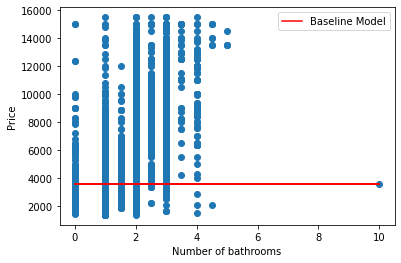

In [ ]:
# A plot of the baseline model fit on the price v bathrooms
plt.scatter(df['bathrooms'], df['price'])
plt.plot(df['bathrooms'], y_pred, label='Baseline Model', color='red')
plt.xlabel('Number of bathrooms')
plt.ylabel('Price')
plt.legend();

#IV Build The Model

In [ ]:
# Import predictor
from sklearn.linear_model import LinearRegression

# Instantiate predictor
model = LinearRegression()

# Fit predictor on training data
model.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

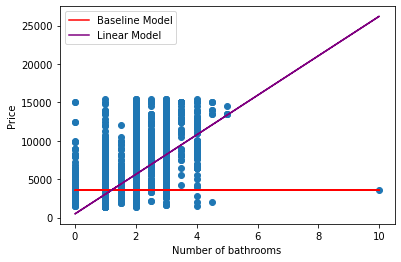

In [ ]:
# An overlay of a Linear regression fit of price v bathrooms on the baseline plot
plt.scatter(df['bathrooms'], df['price'])
plt.plot(df['bathrooms'], y_pred, label='Baseline Model', color='red')
plt.plot(df['bathrooms'], model.predict(X), label='Linear Model', color='purple')
plt.xlabel('Number of bathrooms')
plt.ylabel('Price')
plt.legend();

#V. Check Metrics

In [ ]:
# Comparison of the baseline error to the regression error
print('Baseline Mean Absolute Error', mae(y, y_pred))
print('Training Meaning Absolute Error', mae(y, model.predict(X)))

Baseline Mean Absolute Error 1201.5251847945751
Training Meaning Absolute Error 889.7567422941115


#VI Linear Regression with multiple features

In [ ]:
# Function to compute MAE for different number of features
# First shown is 1 feature (bathroom)

X = df[['bathrooms']]
y = df['price']

def my_error(X, y=y):
  """
  This function takes X (features), then computes and 
  prints out the mean absolute error.
  """
  model.fit(X,y)
  the_error = mae(y, model.predict(X))
  print(f'For the {len(X.columns)} shown features, the Mean Absolute Error is ${the_error:.2f}')
my_error(X)

For the 1 shown features, the Mean Absolute Error is $889.76


In [ ]:
# Checking error for more features
X = df[['total_rooms','latitude','longitude','pets_allowed','new_interest_level','laundry']]
my_error(X)

For the 6 shown features, the Mean Absolute Error is $771.53


In [ ]:
# More feature
X = df[['bathrooms','bedrooms','latitude','longitude','pets_allowed','new_interest_level', 'laundry']]
my_error(X)

For the 7 shown features, the Mean Absolute Error is $711.12


#VI. A Widget to predict rental cost in NYC based on the model

In [ ]:
px.scatter(df, x='bathrooms', y='price', trendline='ols')

In [ ]:
df.bathrooms.unique()

array([ 1.5,  1. ,  2. ,  3.5,  3. ,  2.5,  0. ,  4. , 10. ,  4.5,  5. ])

In [ ]:
from ipywidgets import interact

def rent_predict(num_baths):
  X = df[['bathrooms']]
  y = df['price']
  model.fit(X, y)
  y_pred = model.intercept_ + model.coef_ * num_baths # Model equation
  estimate = y_pred[0]
  print(f'For an apartment with {num_baths:.1f} bathrooms in NYC,\nthe estimated rent is ${estimate:.2f}')

def main():
  # from the bathroom data, min is 0 and max is 10 but 10 is most likely
  # an outlier. So I used 4.5 for the max in the widget
  print("Move the slider to select you desired number of bathrooms")
  interact(rent_predict, num_baths=(0, 4.5, 0.5)) 

if __name__ == "__main__":
        main()

Move the slider to select you desired number of bathrooms


interactive(children=(FloatSlider(value=2.0, description='num_baths', max=4.5, step=0.5), Output()), _dom_clas…